# Radial Distribution Function Results

In this notebook we present the results for the radial distribution function (RDF) , $g(r)$. Loosely speaking, the RDF is a measure of local density. The idea is as follows. Suppose we want to calculate the RDF between two groups A and B. We pick a reference particle in group A. We then consider a shell of radius $r$ away from the reference particle. We then count all the occurences of the reference particles of group B in this shell. We do this up until distances $\frac{1}{2} * \text{box length}$, after which the RDF becomes meaningless due to periodic boundary conditions. We then do this for all reference particles in group A.

There are a few caveats. First of all is normalisation. One can either normalise with the average density or the instantaneous density. For a simulation where the box size doesn't change, both of these approaches are equivalent, however when the box size does change, such as in an NPT simulation, we must use the instantaneous density. Another caveat is the concept of self exclusion. When considering the RDF between the same two groups, we must exclude "self correlations". This is because these cause asymptotic spikes at $r=0$, which are clearly unphysical.

Here we consider three RDFS, for our dry configuration of naproxen/PVP (NAP/PVP). We consider the following RDFs:
* API-API
* Polymer-Polymer
* API-Polymer

The reference particle for the API is the centres of mass (COMs), and the reference particle for the polymer is the user's choice - done by correctly inputting the desired atom with the naming convention in the `.pdb` file. For our PVP result, we used the nitrogen atom.

### Is `MDAnalysis` Safe to Use? (YES!)

One thing that needs to be checked is the validity of using `MDAnalysis`. This is because we need to check if it using the the instantaneous density normalisation convention over the average density normalisation convention. This is particularly important because we are doing NPT runs which do change the box size at every frame. To verify if `MDAnalysis` is safe to use, we test the outputs produced by it to a RDF calculator coded from scratch. To keep things simple, we just test it on the API.

/storage/chem/phuqdw/breaking-bad/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


API COM file test_api.npz already exists, skipping extraction.


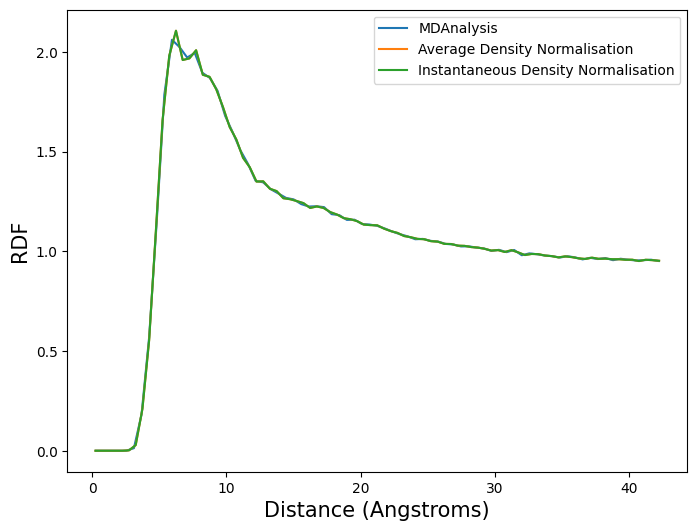

In [1]:
import rdf_analysis
import matplotlib.pyplot as plt

# ----- NVT Simulation ------

# Collecting the bins and the RDF from the MDAnalysis and manual implementation
mda_bins_nvt, mda_rdf_nvt = rdf_analysis.api_api_rdf(
    topology_file="dry_npt.tpr",
    trajectory_file="dry_nvt_trim_whole.xtc",
    api_residue_name="NAP",
    simulation_information_filename="test_api.npz",
    start_time=2000,
    frame_strides=[1],
    nbins=75,
)
man_bins_nvt_avg, man_rdf_nvt_avg = rdf_analysis.api_api_rdf_manual(
    simulation_information_filename="test_api.npz", bin_width=0.5, instantaneous=False
)
man_bins_nvt_inst, man_rdf_nvt_inst = rdf_analysis.api_api_rdf_manual(
    simulation_information_filename="test_api.npz", bin_width=0.5, instantaneous=True
)

# Plotting this information for the check
plt.figure(figsize=(8, 6))
plt.plot(mda_bins_nvt, mda_rdf_nvt[0], label="MDAnalysis")
plt.plot(man_bins_nvt_avg, man_rdf_nvt_avg, label="Average Density Normalisation")
plt.plot(
    man_bins_nvt_inst, man_rdf_nvt_inst, label="Instantaneous Density Normalisation"
)
plt.xlabel("Distance (Angstroms)", fontsize=15)
plt.ylabel("RDF", fontsize=15)
plt.legend()
plt.savefig("manual_vs_mda_test_nvt.png", dpi=300)


Here we can see that there is perfect agreement up to noise from the number of bins. This tells us that when the box size doesn't fluctuate, the average density normalisation is equivalent to an instantaneous density normalisation. This however does not give any insight to the method that MDAnalysis is using.

API COM file test_api_npt.npz already exists, skipping extraction.


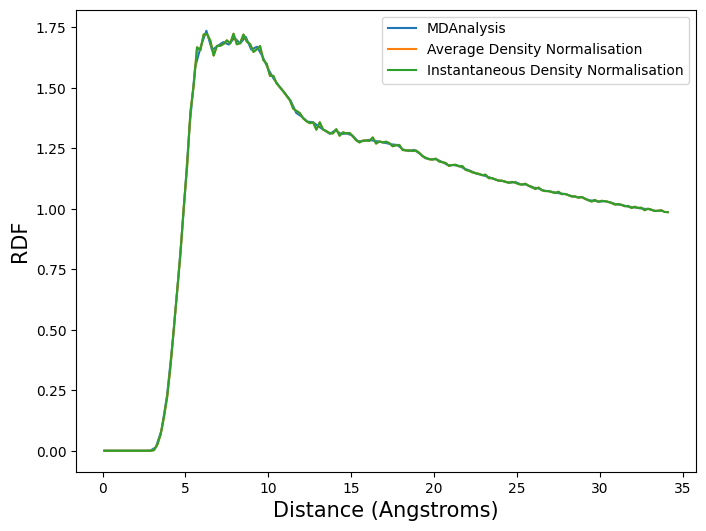

In [ ]:
# ----- NPT Simulation ------
mda_bins_npt, mda_rdf_npt = rdf_analysis.api_api_rdf(
    topology_file="dry_npt.tpr",
    trajectory_file="dry_npt_trim_whole.xtc",
    api_residue_name="NAP",
    simulation_information_filename="test_api_npt.npz",
    start_time=2000,
    frame_strides=[1],
    nbins=100,
)
man_bins_npt_avg, man_rdf_npt_avg = rdf_analysis.api_api_rdf_manual(
    simulation_information_filename="test_api_npt.npz",
    bin_width=0.2,
    instantaneous=False,
)
man_bins_npt_inst, man_rdf_npt_inst = rdf_analysis.api_api_rdf_manual(
    simulation_information_filename="test_api_npt.npz",
    bin_width=0.2,
    instantaneous=True,
)

plt.figure(figsize=(8, 6))
plt.plot(mda_bins_npt, mda_rdf_npt[0], label="MDAnalysis")
plt.plot(man_bins_npt_avg, man_rdf_npt_avg, label="Average Density Normalisation")
plt.plot(
    man_bins_npt_inst, man_rdf_npt_inst, label="Instantaneous Density Normalisation"
)
plt.xlabel("Distance (Angstroms)", fontsize=15)
plt.ylabel("RDF", fontsize=15)
plt.legend()
plt.savefig("manual_vs_mda_test_npt.png", dpi=300)

Some comments...
* So the instantaneous and average agree in the NPT case - this is because box fluctuations are small
* Unfortunately these also agree very closely with MDAnalysis meaning we can't infer what normalisation scheme it is using.

# TASK - Write code to manually calculate the RDF of the other groups